This code reads in two CSV files named 'test.csv' and 'train.csv', cleans the data by filling in missing values with empty strings, creates a new column in the training dataframe called 'text_corpus' by concatenating the 'author', 'title', and 'text' columns, and then creates several dataframes for different columns in the training dataframe. It also creates a date table for article dates and loads all the dataframes into a PostgreSQL database using SQLAlchemy.

After loading the data into the database, it uses pd.read_sql_query() to query the database and display the first 15 rows of each table.

#### Dataset used - https://www.kaggle.com/fake-news/data

### Dataset Description

train.csv: A full training dataset with the following attributes:

* id: unique id for a news article
* title: the title of a news article
* author: author of the news article
* text: the text of the article; could be incomplete
* label: a label that marks the article as potentially unreliable
  * 1: FAKE
  * 0: TRUE


Ensure the file creator is installed to save the MODELS for use in Heroku app

Set the dependencies

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/jonowood/Project-4-A-Team/blob/JonBranch/ML/JONO_PREDICT_MASTER.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a href="https://github.com/jonowood/Project-4-A-Team/blob/JonBranch/ML/JONO_PREDICT_MASTER.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

In [162]:
import numpy as np
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy import inspect
from api_keys import postgres_p

import matplotlib.pyplot as plt

import re 
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
import itertools

import pickle


The Natural Language Toolkit (NLTK) is a platform used for building Python programs that work with human language data for applying in statistical natural language processing (NLP). It contains text processing libraries for tokenization, parsing, classification, stemming, tagging and semantic reasoning.
The nltk.corpus package defines a collection of corpus reader classes, which can be used to access the contents of a diverse set of corpora. The list of available corpora is given at: https://www.nltk.org/nltk_data/ Each corpus reader class is specialized to handle a specific corpus forma

Load and test all the STW ,Stopwords are words which occur frequently in a corpus. e.g a, an, the, in. Frequently occurring words are removed from the corpus for the purpose of text-normalization.

In [163]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jonow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [164]:
# check if Stopwords loaded in english
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [165]:
# Create a single instance of CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

Data Pre-processing and Analysis


Regular Expression Syntax. A regular expression (or RE) specifies a set of strings that matches it; the functions in this module let you check if a particular string matches a given regular expression (or if a given regular expression matches a particular string, which comes down to the same thing

# insert SQL here

In [166]:
# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(database="Project_4", user="postgres", password=postgres_p) #host="your_host_address", port="your_port_number"

In [167]:
# SQL query to retrieve the data
query = "SELECT a.article_id, a.article_label, t.text_corpus FROM article_id a  JOIN text_corpus t ON a.article_id = t.article_id LIMIT 100"

In [168]:
# Execute the query and store the results in a Pandas DataFrame
news_dataset = pd.read_sql_query(query, conn)

In [169]:
# Close the database connection
conn.close()

In [170]:
news_dataset

,article_id,article_label,text_corpus
0,0,1,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,0,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,1,Consortiumnews.com Why the Truth Might Get You...
3,3,1,Jessica Purkiss 15 Civilians Killed In Single ...
4,4,1,Howard Portnoy Iranian woman jailed for fictio...
...,...,...,...
95,72,0,Jacey Fortin Dress Like a Woman? What Does Tha...
96,73,0,"Brett Anderson At 91, Ella Brennan Still Feeds..."
97,74,0,"Jane Perlez Pressing Asia Agenda, Obama Treads..."
98,75,0,Josh Katz Democrats Have a 60 Percent Chance t...


In [171]:
# Now we will separate the data and label i.e. text_corpus and label fields
X = news_dataset['text_corpus']
Y = news_dataset['article_label']

In [172]:
# Define a function for stemming the content
port_stem = PorterStemmer()
def stemming(content):
    # Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed. Numbers or punctuations will be replaced by a whitespace
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    # Converting all letters to lowercase 
    stemmed_content = stemmed_content.lower()
    # Converting all to a splitted case or a list
    stemmed_content = stemmed_content.split()
    # Applying stemming, so we get the root words wherever possible + remove stopwords as well
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    # Join all the words in final content
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [173]:
# Apply stemming to the text_corpus column
X = X.apply(stemming)

In [174]:
# Print the X and Y variables
print(X)
print(Y)

0     darrel lucu hous dem aid even see comey letter...
1     daniel j flynn flynn hillari clinton big woman...
2     consortiumnew com truth might get fire truth m...
3     jessica purkiss civilian kill singl us airstri...
4     howard portnoy iranian woman jail fiction unpu...
                            ...                        
95    jacey fortin dress like woman mean new york ti...
96    brett anderson ella brennan still feed lead ne...
97    jane perlez press asia agenda obama tread ligh...
98    josh katz democrat percent chanc retak senat n...
99    news pr disast presid panason forc resign pana...
Name: text_corpus, Length: 100, dtype: object
0     1
1     0
2     1
3     1
4     1
     ..
95    0
96    0
97    0
98    0
99    1
Name: article_label, Length: 100, dtype: int64


TF-IDF (Term Frequency, Inverse Document Frequency)

### Converting Textual data to Numerical data

* The TF-IDF Vectorizer
* TF-IDF Vectorizer coverts textual data to numerical data

Thsi is still a bit messed up and need to be cleaned, I stidued the HEROKYU app fiel and the vectorizer is use dto translate the input text to ML to do teh comparison

In [175]:
vectorizer.fit(X)

CountVectorizer(stop_words='english')

In [176]:
X_transformed = vectorizer.transform(X)

In [177]:
pickle.dump(vectorizer, open('../Pickles/tfidfvect2.pkl', 'wb'))

In [178]:
TEST_model = pickle.load(open('../Pickles/tfidfvect2.pkl', 'rb'))

print(TEST_model)

CountVectorizer(stop_words='english')


In [179]:
print(X_transformed)

  (0, 18)	1
  (0, 36)	1
  (0, 49)	3
  (0, 70)	1
  (0, 76)	1
  (0, 109)	1
  (0, 144)	1
  (0, 162)	6
  (0, 231)	3
  (0, 253)	1
  (0, 274)	1
  (0, 301)	1
  (0, 309)	1
  (0, 315)	1
  (0, 336)	1
  (0, 347)	1
  (0, 351)	2
  (0, 354)	1
  (0, 478)	1
  (0, 514)	1
  (0, 612)	1
  (0, 639)	1
  (0, 747)	1
  (0, 837)	1
  (0, 898)	1
  :	:
  (99, 6803)	2
  (99, 6816)	2
  (99, 6844)	2
  (99, 6847)	1
  (99, 6886)	1
  (99, 7005)	1
  (99, 7081)	1
  (99, 7116)	5
  (99, 7169)	1
  (99, 7183)	1
  (99, 7236)	1
  (99, 7322)	2
  (99, 7341)	3
  (99, 7374)	3
  (99, 7392)	5
  (99, 7393)	1
  (99, 7492)	1
  (99, 7753)	1
  (99, 7767)	1
  (99, 7776)	2
  (99, 7893)	1
  (99, 7928)	3
  (99, 7940)	1
  (99, 7977)	1
  (99, 7983)	1


---

Modeling & Model Evaluation

### Splitting the data into test and train datasets

In [180]:
# Splitting the data into test and train datasets
X_train_transformed, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size=0.18, random_state=42)

We use 2 models to determine the accuracy of teh training set and will then select the most accurate model to us ein HEREKO
The first Model - Logistic regression

In [181]:
# Training the model
logisticreg_model = LogisticRegression(random_state=42)

logisticreg_model.fit(X_train_transformed, Y_train)

LogisticRegression(random_state=42)

### Model Evaluation

In [182]:
# Accuracy Score on Training Data
X_train_prediction = logisticreg_model.predict(X_train_transformed)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

print('Accuracy score on the training data: ',training_data_accuracy)

# Accuracy Score on Test Data
X_test_prediction = logisticreg_model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

print('Accuracy score on the test data: ',test_data_accuracy)

Accuracy score on the training data:  1.0
Accuracy score on the test data:  0.6111111111111112


In [183]:
import pickle
pickle.dump(logisticreg_model, open('../Pickles/logisticreg_model.pkl', 'wb'))


In [184]:
# Classification report for test data
classification_report(Y_test, X_test_prediction)

'              precision    recall  f1-score   support\n\n           0       0.83      0.45      0.59        11\n           1       0.50      0.86      0.63         7\n\n    accuracy                           0.61        18\n   macro avg       0.67      0.66      0.61        18\nweighted avg       0.70      0.61      0.61        18\n'

**CLASSIFICATION MODEL : PASSIVE AGGRESSIVE CLASSIFIER**

* Passive Aggressive Classifier works by responding as passive for correct classifications and responding as aggressive for any miscalculation.

---

In [185]:
# Create a function to preprocess and stem the text
def stemming(text):
    ps = PorterStemmer()
    review = re.sub('[^a-zA-Z]', ' ', text)
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    return review


In [186]:

# Apply stemming to each text in the array
X_preprocessed = [stemming(text) for text in X]

In [187]:
# Fit and transform the preprocessed data
X_transformed = vectorizer.fit_transform(X_preprocessed)


In [188]:
# Splitting dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size=0.33, random_state=42)


In [189]:
from sklearn.linear_model import PassiveAggressiveClassifier
# Creating model
passive_aggressive_model = PassiveAggressiveClassifier(C=0.5, random_state=5)

In [190]:

# Fitting model
passive_aggressive_model.fit(X_train, Y_train)

PassiveAggressiveClassifier(C=0.5, random_state=5)

In [191]:

# Making prediction on test set
test_pred = passive_aggressive_model.predict(X_test)

In [192]:
# Model evaluation
print(f"Test Set Accuracy : {accuracy_score(Y_test, test_pred) * 100} %\n\n")

Test Set Accuracy : 69.6969696969697 %




In [193]:
# Save the vectorizer
pickle.dump(vectorizer, open('../Pickles/tfidf_vectorizer.pkl', 'wb'))

In [194]:
# Save the model
pickle.dump(passive_aggressive_model, open('../Pickles/passive_aggressive_model.pkl', 'wb'))

In [195]:
# Use the trained models to make predictions on new data
vectorizer = pickle.load(open('../Pickles/tfidf_vectorizer.pkl', 'rb'))
passive_aggressive_model = pickle.load(open('../Pickles/passive_aggressive_model.pkl', 'rb'))

In [196]:
# Assuming X_new is a new text input
X_new = X[5]
X_new_preprocessed = stemming(X_new)
X_new_transformed = vectorizer.transform([X_new_preprocessed])

In [197]:

# Make prediction using the trained model
prediction = passive_aggressive_model.predict(X_new_transformed)

In [198]:
# Print the prediction result
print("Prediction for the new text input: ", prediction[0])
if (prediction[0] == 0):
    print('Jono says it\'s True')
else:
    print('Johan Says it is a porky:)')

Prediction for the new text input:  0
Jono says it's True


---

In [199]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_transformed, Y, test_size=0.33, random_state=42)

In [200]:
pickle.dump(passive_aggressive_model, open('../Pickles/passiveagressive_model.pkl', 'wb'))

Testing the two models

In [201]:
# Importing modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Create the vectorizer
# vectorizer = TfidfVectorizer()

# Fit and transform the input data
X_transformed = vectorizer.fit_transform(X)

# Splitting dataset into train and test sets
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X_transformed, Y, test_size=0.33, random_state=42)

# Creating model
passiveagressive_model = PassiveAggressiveClassifier(C=0.5, random_state=5)

# Fitting model
passiveagressive_model.fit(X2_train, Y2_train)

# Making prediction on test set
test_pred = passiveagressive_model.predict(X2_test)

# Model evaluation
print(f"Test Set Accuracy : {accuracy_score(Y2_test, test_pred) * 100} %\n\n")

# Save the vectorizer
pickle.dump(vectorizer, open('../Pickles/tfidf_vectorizer.pkl', 'wb'))

# Save the model
pickle.dump(passiveagressive_model, open('../Pickles/passiveagressive_model.pkl', 'wb'))

Test Set Accuracy : 69.6969696969697 %




In [202]:
y_pred = logisticreg_model.predict(X2_test)

# Calculate the prediction accuracy
accuracy = np.mean(y2_pred == Y_test) * 100

# Print the accuracy
print("Prediction accuracy: {:.2f}%".format(accuracy))

# Print the prediction for a single example
X_new = X2_test[5]
prediction = logisticreg_model.predict(X_new.reshape(1, -1))
print("Prediction for example 500: ", prediction[0])
if (prediction[0] == 0):
  print('Jono says its True')
else:
  print('Johan Says it is a porky:)')

Prediction accuracy: 78.79%
Prediction for example 500:  0
Jono says its True


In [203]:
y2_pred = logisticreg_model.predict(X2_test)

# Calculate the prediction accuracy
accuracy = np.mean(y2_pred == Y2_test) * 100

# Print the accuracy
print("Prediction accuracy: {:.2f}%".format(accuracy))

# Print the prediction for a single example
X2_new = X2_test[5]
prediction2 = passiveagressive_model.predict(X2_new.reshape(1, -1))
print("Prediction for example 500: ", prediction[0])
if (prediction[0] == 0):
  print('Jono says its True')
else:
  print('Johan Says it is a porky:)')

Prediction accuracy: 78.79%
Prediction for example 500:  0
Jono says its True


In [204]:
news_dataset[10:11]

,article_id,article_label,text_corpus
10,10,0,Aaron Klein Obama’s Organizing for Action Part...


In [205]:
print(Y_test)

83    1
53    0
70    0
45    0
44    0
39    0
22    1
80    0
10    0
0     1
18    1
30    0
73    1
33    0
90    0
4     1
76    1
77    0
12    1
31    1
55    0
88    1
26    1
42    1
69    1
15    0
40    0
96    0
9     0
72    1
11    0
47    0
85    1
Name: article_label, dtype: int64


In [206]:
print(Y_test)

83    1
53    0
70    0
45    0
44    0
39    0
22    1
80    0
10    0
0     1
18    1
30    0
73    1
33    0
90    0
4     1
76    1
77    0
12    1
31    1
55    0
88    1
26    1
42    1
69    1
15    0
40    0
96    0
9     0
72    1
11    0
47    0
85    1
Name: article_label, dtype: int64


In [207]:
news_dataset[3:4]

,article_id,article_label,text_corpus
3,3,1,Jessica Purkiss 15 Civilians Killed In Single ...


In [208]:
# vectorizer = pickle.load(open('../Pickles/tfidfvect2.pkl', 'rb'))
# print(X)
# vectorizer.fit(X)

In [209]:
# Assuming X is an array of text inputs
X_preprocessed = [stemming(text) for text in X]  # Apply stemming to each text in the array
X_vectorized = vectorizer.transform(X_preprocessed)  # Convert to numerical format using the trained vectorizer



In [210]:
pickled_model1 = pickle.load(open('../Pickles/logisticreg_model.pkl', 'rb'))
predictions = pickled_model1.predict(X_vectorized)

In [211]:
pickled_model2 = pickle.load(open('../Pickles/passiveagressive_model.pkl', 'rb'))
pickled_model2.predict(X2_test)

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

FAngo tested a point to clarify teh vector model

In [212]:
ps = PorterStemmer()

In [213]:
review = re.sub('[^a-zA-Z]', ' ', news_dataset['text_corpus'][10])
review = review.lower()
review = review.split()
review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
review = ' '.join(review)
review

'aaron klein obama organ action partner soro link indivis disrupt trump agenda organ action activist group morph barack obama first presidenti campaign partner indivis project onlin train protest presid donald trump agenda last week breitbart news extens report indivis leader openli associ group financ billionair georg soro politico earlier month profil indivis articl titl insid protest movement republican reel news agenc left soro link fail note organ cite articl help amplifi indivis messag either financ directli soro close tie group fund billionair breitbart news document organ action ofa commun organ project sprung obama campaign organ organ america becom nonprofit describ washington post advoc ing presid polici recent facebook post titl take deep breath take action ofa call constitu lobbi particularli hard februari lawmak home district post includ link guid releas indivis organ trump stay tune onlin train invit call coalit partner like indivis guid ofa post state paul sperri write 

In [214]:
val = vectorizer.transform([review]).toarray()

In [215]:
tfidfvect2_model2 = pickle.load(open('tfidfvect2.pkl', 'rb'))


In [216]:
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [217]:
from sklearn.metrics import classification_report, confusion_matrix


# Model 2: Passive Aggressive Classifier
y_pred2 = passiveagressive_model.predict(X2_test)
accuracy2 = np.mean(y_pred2 == Y2_test) * 100

print("Passive Aggressive Classifier Model Results")
print("--------------------------------------------")
print("Prediction accuracy: {:.2f}%".format(accuracy2))
print("\nClassification Report:")
print("--------------------------------------------")
print(classification_report(Y2_test, y_pred2))
print("Confusion Matrix:")
print(confusion_matrix(Y2_test, y_pred2))


Passive Aggressive Classifier Model Results
--------------------------------------------
Prediction accuracy: 69.70%

Classification Report:
--------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.65      0.73      0.69        15

    accuracy                           0.70        33
   macro avg       0.70      0.70      0.70        33
weighted avg       0.70      0.70      0.70        33

Confusion Matrix:
[[12  6]
 [ 4 11]]


In [218]:
from sklearn.metrics import classification_report, confusion_matrix

# # Model 1: Logistic Regression
y_pred1 = logisticreg_model.predict(X2_test)
accuracy1 = np.mean(y_pred1 == Y2_test) * 100

print("Logistic Regression Model Results")
print("----------------------------------")
print("Prediction accuracy: {:.2f}%".format(accuracy1))
print("\nClassification Report:")
print("--------------------------------------------")
print(classification_report(Y_test, y_pred1))
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred1))
print("\n")


Logistic Regression Model Results
----------------------------------
Prediction accuracy: 78.79%

Classification Report:
--------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.67      0.77        18
           1       0.70      0.93      0.80        15

    accuracy                           0.79        33
   macro avg       0.81      0.80      0.79        33
weighted avg       0.82      0.79      0.79        33

Confusion Matrix:
[[12  6]
 [ 1 14]]




In [219]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
logreg_param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Define the parameter grid for Passive Aggressive Classifier
pac_param_grid = {
    'C': np.logspace(-4, 4, 20),
    'loss': ['hinge', 'squared_hinge']
}

In [220]:
# Initialize the models
logreg = LogisticRegression()
pac = PassiveAggressiveClassifier()

In [221]:
# Perform GridSearchCV for Logistic Regression
logreg_grid_search = GridSearchCV(logreg, logreg_param_grid, cv=5, verbose=0)
logreg_grid_search.fit(X_transformed, Y)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [222]:
# Perform GridSearchCV for Passive Aggressive Classifier
pac_grid_search = GridSearchCV(pac, pac_param_grid, cv=5, verbose=0)
pac_grid_search.fit(X_transformed, Y)

GridSearchCV(cv=5, estimator=PassiveAggressiveClassifier(),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'loss': ['hinge', 'squared_hinge']})

In [223]:

# Get the best parameters for both models
best_logreg_params = logreg_grid_search.best_params_
best_pac_params = pac_grid_search.best_params_

In [224]:
# Train the models with best parameters
best_logreg_model = LogisticRegression(**best_logreg_params)
best_pac_model = PassiveAggressiveClassifier(**best_pac_params)


In [225]:
# Calculate the accuracies and record the changes
logreg_accuracies = logreg_grid_search.cv_results_['mean_test_score']
pac_accuracies = pac_grid_search.cv_results_['mean_test_score']

In [226]:
best_logreg_model.fit(X_train, Y_train)

LogisticRegression(C=206.913808111479, penalty='l1', solver='liblinear')

In [227]:
best_pac_model.fit(X2_train, Y2_train)

PassiveAggressiveClassifier(C=206.913808111479)

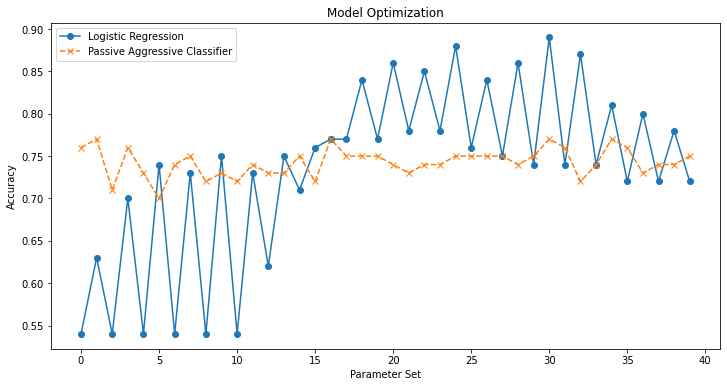

In [228]:
# Plot changes
plt.figure(figsize=(12, 6))
plt.plot(logreg_accuracies, label="Logistic Regression", linestyle="-", marker="o")
plt.plot(pac_accuracies, label="Passive Aggressive Classifier", linestyle="--", marker="x")
plt.xlabel("Parameter Set")
plt.ylabel("Accuracy")
plt.title("Model Optimization")
plt.legend()
plt.show()